## Exercise 1: ARX model and Hammerstein
# ARX


dict_keys(['__header__', '__version__', '__globals__', 'para', 't', 'u', 'y'])


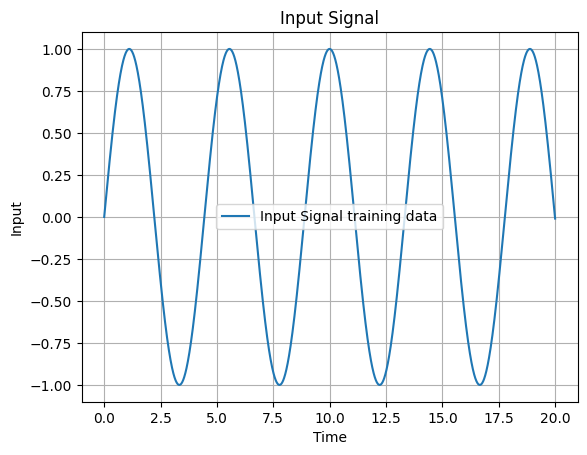

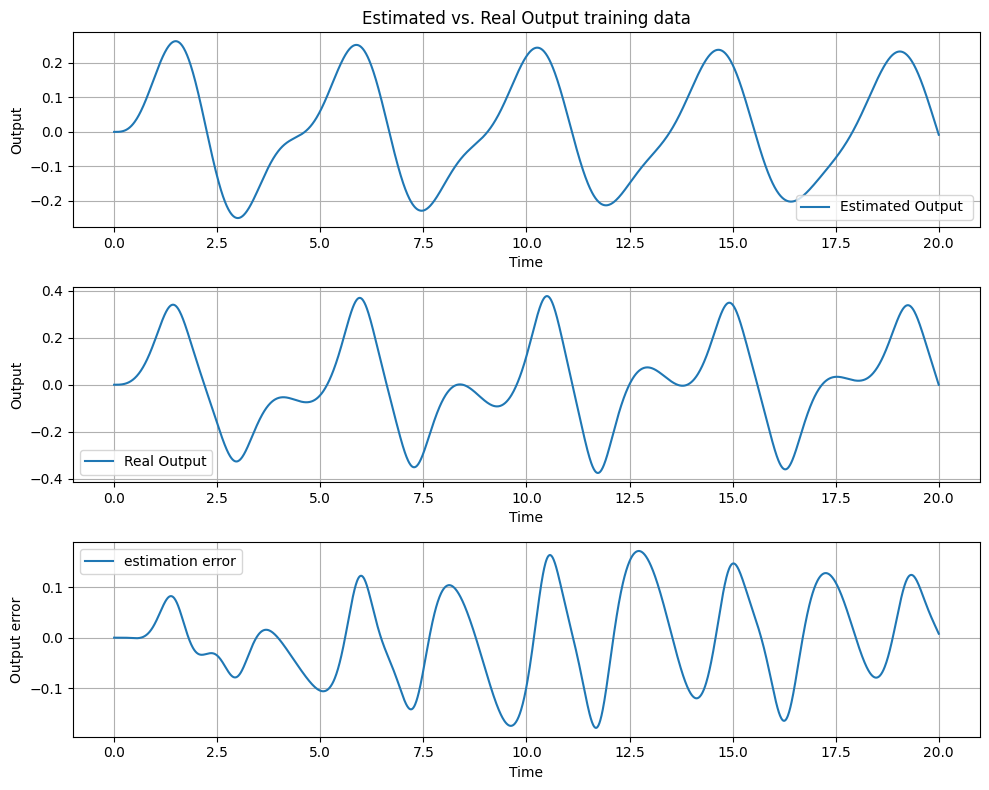

In [2]:
from scipy.io import loadmat
from scipy.signal import freqz, dlti, dlsim
import numpy as np
from numpy import shape
import matplotlib.pyplot as plt

#extracting the Data from the .mat file file
data=loadmat("C:\\KIT\\Master_KIT\\DMC\\20240613_hoerter\\20240613_hoerter\\ex1_data.mat")

#show what the values are:
print(data.keys())
u1=np.array(data['u'].T)
y1=np.array(data['y'])
t1=np.array(data['t'].T)
para=(data['para'])


na=3
nb=2
Ts=np.max(t1)/(len(t1)-1)

#---------------------------------------------------------------------------------------------------------------------------

#initial Values for the estimation
Pini=np.array(10**7*np.eye(na+nb+1))
pini=np.zeros(na+nb+1)

sky=np.zeros(na)
sku=np.zeros(nb+1)
skT = np.hstack((sky.T, sku.T))

#---------------------------------------------------------------------------------------------------------------------------

#recursive algorithm

for k in range(0,len(t1)):
    yk=np.array(y1[k])
    uk=u1[k]
    
    if k==0:
        sky[1:na]=sky[0:na-1]
        sky[0]=0     
    else:  
        sky[1:na]=sky[0:na-1]
        sky[0]=y1[k-1,0]                     #teil für y
                                 
                  
   
                                        #Teil für u
    sku[1:nb+1]=sku[0:nb]
    sku[0]=u1[k,0] 

    skT=np.hstack((sky.T,sku.T)).reshape(1,na+nb+1)
    sk=np.array(skT.T).reshape(na+nb+1,1)
    
    #estimate of parameter vector p:
    kk=(Pini@sk/(1+skT@Pini@sk)).reshape(na+nb+1,1)
    Pini=Pini-kk@skT@Pini
    pini=pini+kk@(yk-skT@pini)
 
#---------------------------------------------------------------------------------------------------------------------------
#Estimation and discrete transfer function

b = pini[na:].flatten()
a = np.concatenate(([1], -pini[:na].flatten()))
system=dlti(b,a,dt=Ts)


#simulating system response
t = np.arange(len(t1)) * Ts
tout, yest = dlsim(system, u1,t)  #simulation for dataset 1

#tout2, yest2= dlsim(system,u2,t)                       #simulation for (possible) dataset 2

#---------------------------------------------------------------------------------------------------------------------------

plt.figure()
plt.plot(t1, u1, label='Input Signal training data')
plt.title('Input Signal')
plt.xlabel('Time')
plt.ylabel('Input')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 8))

# Plot the estimated output response
plt.subplot(3, 1, 1)  # 2 rows, 1 column, subplot 1
plt.plot(t1, yest, label='Estimated Output ')
plt.title('Estimated vs. Real Output training data')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.grid()

# Plot the real output
plt.subplot(3, 1, 2)  # 2 rows, 1 column, subplot 2
plt.plot(t1, y1, label='Real Output')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)  # 2 rows, 1 column, subplot 3
plt.plot(t, y1-yest, label='estimation error')
plt.xlabel('Time')
plt.ylabel('Output error')
plt.legend()
plt.grid()
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()




## Hammerstein Model

dict_keys(['__header__', '__version__', '__globals__', 'para', 't', 'u', 'y'])


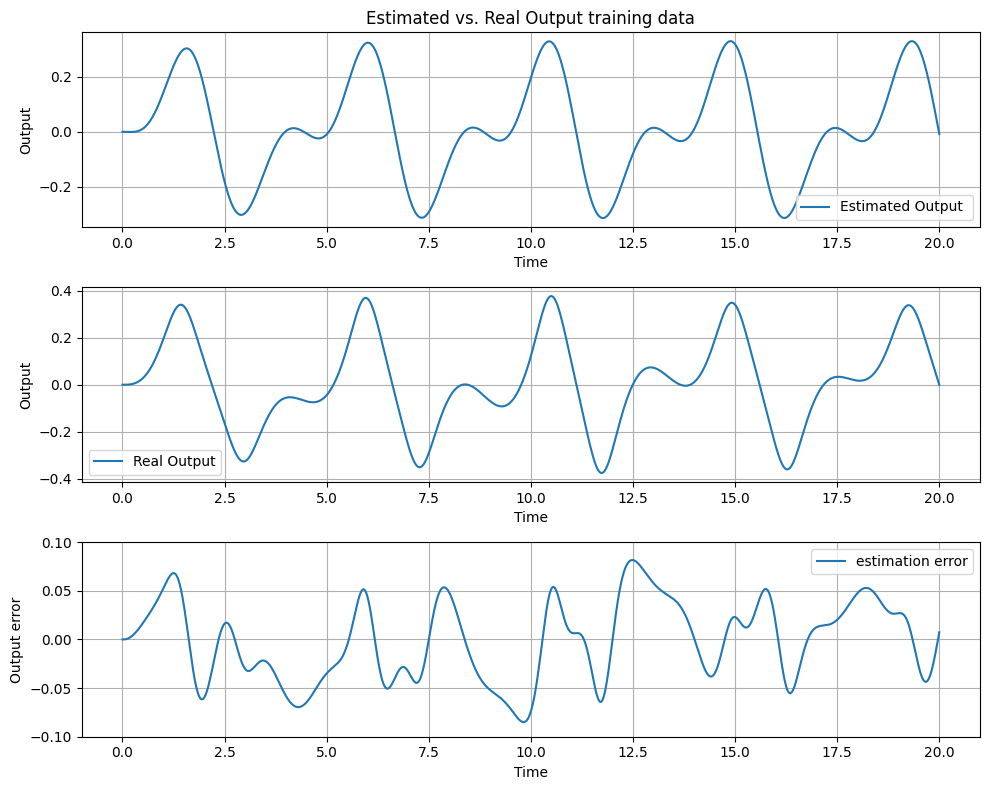

In [3]:
from scipy.io import loadmat
from scipy.signal import freqz, dlti, dlsim
import numpy as np
import matplotlib.pyplot as plt

#extracting the Data from the matlab file

#extracting the Data from the .mat file file
data=loadmat("C:\\KIT\\Master_KIT\\DMC\\20240613_hoerter\\20240613_hoerter\\ex1_data.mat")

#show what the values are:
print(data.keys())
u1=np.array(data['u'].T)
y1=np.array(data['y'])
t1=np.array(data['t'].T)
para=(data['para'])


#order of polynomial for Hammerstein p needs to be declared
p=3
na=4
nb=3
Ts=np.max(t1)/(len(t1)-1)
#print(Ts)
#---------------------------------------------------------------------------------------------------------------------------

#initial Values for the estimation
Pini=np.array(10**6*np.eye(na+p*(nb+1)))
pini=np.zeros(na+p*(nb+1))

sky=np.zeros(na)
sku=np.zeros(nb+1)
skT =np.zeros(na+p*(nb+1))
Sn=skT
#-----------------------------------------------------------------------------------------------------------------------------
#recursive algorithm

for k in range(0,len(t1)):
    yk=y1[k,0] 
    uk=u1[k]
    
    if k==0:
        sky[1:na]=sky[0:na-1]
        sky[0]=0     
    else:  
        sky[1:na]=sky[0:na-1]
        sky[0]=y1[k-1,0]                     #teil für y
                                 
                  
   
                                        #Teil für u
    sku[1:nb+1]=sku[0:nb]
    sku[0]=u1[k,0] 
    sku_=sku
    for i in range(2,p+1):
        sku_=np.concatenate((sku_, sku**i))
    
    


    skT=np.hstack((sky.T,sku_.T)).reshape(1,na+p*(nb+1))
    sk=np.array(skT.T).reshape(na+p*(nb+1),1)
    
    #estimate of parameter vector p:
    kk=(Pini@sk/(1+skT@Pini@sk)).reshape(na+p*(nb+1),1)
    Pini=Pini-kk@skT@Pini
    pini=pini+kk@(yk-skT@pini)
    if k>0: 
        Sn=np.vstack((Sn,skT))

#-----------------------------------------------------------------------------------------------------------------------


#now its a little harder to calculate the system response since we cannot set up the transfer function as easily. 
#however we do have the parameter vector pini that we calculated through our recursion. Assume now that the input is known, but we 
#do not have knowledge of the ouput. So using yest=Sn*pini would not yield a satisfying solution. After all, if we already knew the ouput 
#beforehand, we would not have to calculate it.

#Assuming we have the input

sy=np.zeros(na)
su=np.zeros(nb+1)
yest=np.zeros(len(t1))

for k in range(0,len(t1)):
    #lets start at time step 0: we only have the input u in our skT vector
    su[1:nb+1]=su[0:nb]
    su[0]=u1[k,0]
    su_=su
    for i in range(2,p+1):
        su_=np.concatenate((su_,su**i))
    skT=np.hstack((sy.T,su_.T))
    #key step to get the estimated y vector
    yest[k]=skT@pini
    #updating our sy vector
    sy[1:na]=sy[0:na-1]
    sy[0]=yest[k]


#----------------------------------------------------------------------------------------------
#computing the error as follows: 

e=np.zeros(len(t1))
for i in range(0,len(t1)):
    e[i]=y1[i,0]-yest[i]



#-------------------------------------------------------------------------------------



plt.figure(figsize=(10,8))
# Plot the estimated output response
plt.subplot(3, 1, 1)  # 2 rows, 1 column, subplot 1
plt.plot(t1, yest, label='Estimated Output ')
plt.title('Estimated vs. Real Output training data')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.grid()

# Plot the real output
plt.subplot(3, 1, 2)  # 2 rows, 1 column, subplot 2
plt.plot(t1, y1, label='Real Output')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)  # 2 rows, 1 column, subplot 3
plt.plot(t1, e, label='estimation error')
plt.xlabel('Time')
plt.ylabel('Output error')
plt.legend()
plt.grid()
plt.tight_layout() 
plt.ylim(-0.1,0.1) # Adjust layout to prevent overlapping
plt.show()





## DMD with control

dict_keys(['__header__', '__version__', '__globals__', 'X', 't', 'u'])


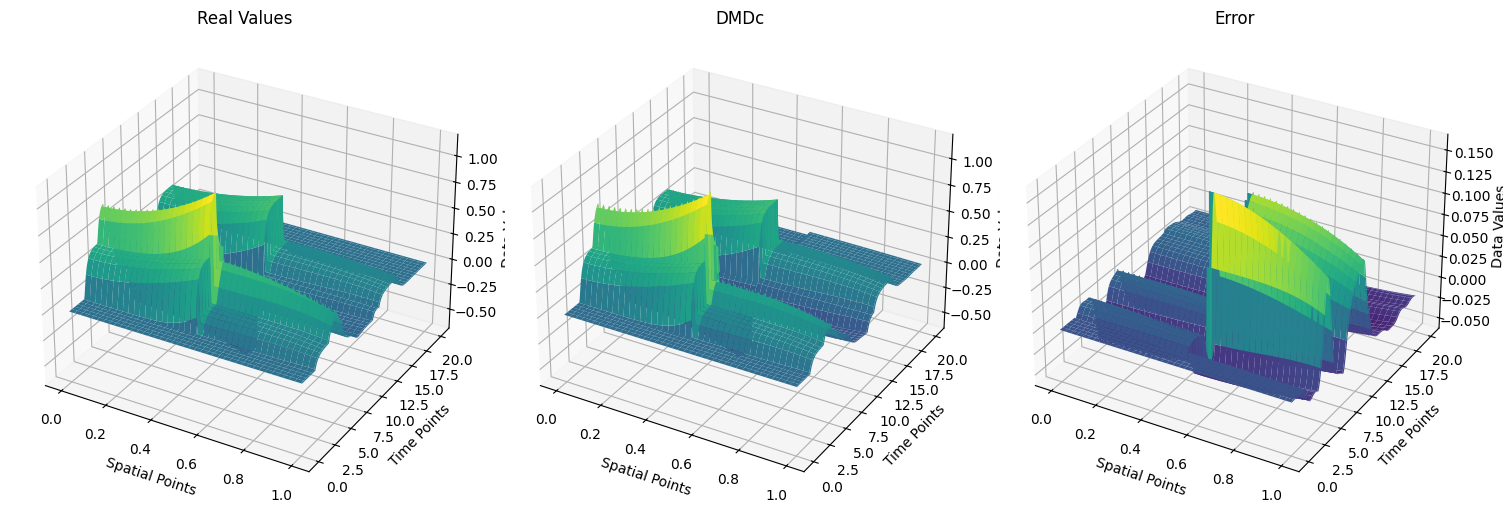

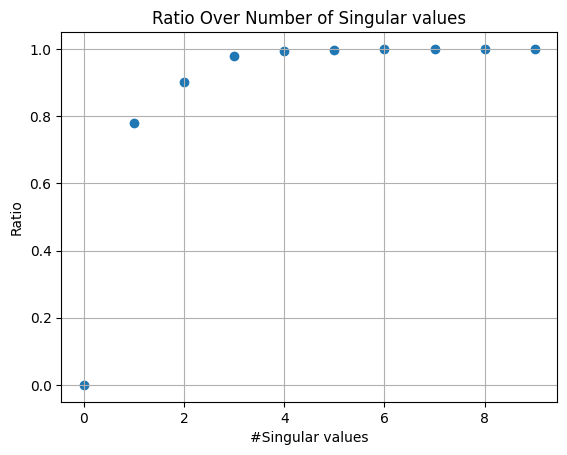

In [4]:
from scipy.io import loadmat
from scipy.signal import freqz, dlti, dlsim
import numpy as np
from numpy import shape
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#---------------------------------------------------------------------------------------------------------------------------

#extracting the Data from the matlab file

data=loadmat(r'C:\KIT\Master_KIT\DMC\20240613_hoerter\20240613_hoerter\ex2_data.mat')
print(data.keys())

x=data['X']
t=data['t']
u=data['u']

#we now create the snapshot matrices of the output y
X=x[:,:-1]
Xp=x[:,1:]
Uin=u[:,0:-1]
#---------------------------------------------------------------------------------------------------------------------------

Omega=np.vstack((X,Uin))

#single value decomposition of X
U,S,Vt=np.linalg.svd(Omega)
#order of approximation
p=np.linalg.matrix_rank(Omega)
r=10

if r>p:
   r=p


U=U[:,0:r]
#Abspeichern der singular values für part 2
sings = S
S = np.diag(S)[0:r,0:r]
Vt = Vt[0:r,:]

#---------------------------------------------------------------------------------------------------------------------------
UT = U.T
V = Vt.T
Sinv = np.linalg.inv(S)

#number of inputs 
nb = 2
#number of states (or in this case outputs)
nx = 202
#after the SVD we compute the solution to our system by:
G = Xp@V@Sinv@UT
# splitting our system matrix G into [A,B] 
A = G[:,:nx]
B = G[:, nx:]
#---------------------------------------------------------------------------------------------------------------------------

#dimension reduction now with At=Uh* Xp V S^-1 U1* Uh =Uh* A U ,
#with Uh from the single value decomposition of the output space

Uh,Sh,Vth = np.linalg.svd(Xp)

Uh = Uh[:,0:r]
UhT = Uh.T

At = UhT@A@Uh
Bt = UhT@B
#---------------------------------------------------------------------------------------------------------------------------
#calculating the ouput in the reduced order system with the input u
x0 = X[:,0]
z = np.zeros((r,len(t.T)))
z[:,0] = UhT@x0

for i in range(1,len(t.T)):
    z[:,i] = At@z[:,i-1] +Bt@u[:,i]

#backtransformation to the original system order
xt = Uh@z
#---------------------------------------------------------------------------------------------------------------------------



#now just plot it 
#Generating the mesh


Zaxis=np.linspace(0, 1, len(x))
Z, T = np.meshgrid(Zaxis, t, indexing='ij')


#---------------------------------------------------------------------------------------------------------------------------


# Plotting
fig = plt.figure(figsize=(15, 5))

# Plot the real values
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(Z, T, x, cmap='viridis')
ax1.set_xlabel('Spatial Points')
ax1.set_ylabel('Time Points')
ax1.set_zlabel('Data Values')
ax1.set_title('Real Values')

# Plot the DMDc values
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(Z, T, xt, cmap='viridis')
ax2.set_xlabel('Spatial Points')
ax2.set_ylabel('Time Points')
ax2.set_zlabel('Data Values')
ax2.set_title('DMDc')

# Plot the error
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(Z, T, x-xt, cmap='viridis')
ax3.set_xlabel('Spatial Points')
ax3.set_ylabel('Time Points')
ax3.set_zlabel('Data Values')
ax3.set_title('Error')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()



#---------------------------------------------------------------------------------------------------------------------------

#part b) we have 204 eigenvalues
ratio=np.zeros(len(sings))
sumsings=np.sum(sings)
for i in range(0,len(sings)):
    ratio[i]=np.sum(sings[:i])/sumsings

Number_of_sings = np.arange(0, 204)

plt.scatter(Number_of_sings[:10], ratio[:10])
plt.xlabel('#Singular values')
plt.ylabel('Ratio')
plt.title('Ratio Over Number of Singular values')
plt.grid(True)
plt.show()
